<h4>Problem Statement</h4>

Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to <strong>predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.</strong>

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

<strong>Evaluation Metric:</strong> ROC AUC score

<h4>Variable Definition</h4>

1. id==>	Unique ID for the customer
2. Gender ==>	Gender of the customer

3. Age ==> Age of the customer

4. Driving_License ==>	0 : Customer does not have DL, 1 : Customer already has DL

5. Region_Code ==>	Unique code for the region of the customer

6. Previously_Insured ==>	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

7. Vehicle_Age ==>	Age of the Vehicle 

8. Vehicle_Damage ==> 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

9. Annual_Premium ==> The amount customer needs to pay as premium in the year

10. Policy_Sales_Channel ==> Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

11. Vintage ==> Number of Days, Customer has been associated with the company

12. Response (Target) ==>	1 :  Customer is interested, 0 : Customer is not interested

In [1]:
path = "C:/Machine_learning_datafiles/AnalyticsVidya/CrossSell"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')
os.chdir(path)

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import missingno as msno
import random

In [350]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import balanced_accuracy_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
import catboost as cat
import lightgbm as lgb
from rgf.sklearn import RGFClassifier

In [19]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [20]:
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-dark')
%matplotlib inline

In [124]:
def modelMetric(model, xtrain, xval):
    tr_auc = roc_auc_score(ytrain, model.predict_proba(xtrain)[:,1])
    val_auc = roc_auc_score(yval, model.predict_proba(xval)[:,1])
    tr_bas = balanced_accuracy_score(ytrain, model.predict(xtrain))
    val_bas = balanced_accuracy_score(yval, model.predict(xval))
    print(f'Train AUC: {tr_auc.round(5)} Train Bal. Acc : {tr_bas.round(5)}')
    print(f'Val AUC: {val_auc.round(5)} Val Bal. Acc : {val_bas.round(5)}')

In [260]:
def figurePlotting(model):
    fig, ax= plt.subplots(1,3,figsize=(12,3.5))
    plot_confusion_matrix(model, xval, yval, ax=ax[0], display_labels=['No', 'Yes'])
    plot_roc_curve(model, xval, yval, ax=ax[1])
    plot_precision_recall_curve(model, xval, yval, ax=ax[2])
    ax[0].set_title('Confusion Matrix')
    ax[1].set_title('ROC Curve')
    ax[2].set_title('PR-Curve')
    for i in range(3):
        ax[i].grid(False)
    plt.tight_layout(pad=1.)

In [196]:
def TrainModel(model, xtrain, xval):
    if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
        model.fit(xtrain, ytrain, eval_set=[(xval, yval)],
                 early_stopping_rounds=250, verbose=False)
    else:
        model.fit(xtrain, ytrain)
    modelMetric(model, xtrain, xval)
    return model

In [288]:
def skfoldPred(model, X, testset):
    avg_auc, avg_bas = 0,0
    test_preds = []
    for fold, (tr_idx, val_idx) in enumerate(skfold.split(X, y), start=1):
        x_train, y_train = X.iloc[tr_idx], y.iloc[tr_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if model.__class__.__name__ in ['CatBoostClassifier', 'LGBMClassifier']:
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], 
                      early_stopping_rounds=250, verbose=False)
        else:
            model.fit(x_train, y_train)
        val_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
        val_bas = balanced_accuracy_score(y_val, model.predict(x_val))
        print(f'Fold {fold} ===> Val AUC: {val_auc.round(5)} Val BAS:{val_bas.round(5)}')
        avg_auc += val_auc
        avg_bas += val_bas
        
        y_pred = model.predict_proba(testset)[:,1]
        test_preds.append(y_pred)
    print(f'AVG AUC: {avg_auc/fold} AVG Bal. ACC: {avg_bas/fold}')
    return np.mean(test_preds, 0).astype('float32')

In [11]:
def read_files(filename): return pd.read_csv(filename)

In [198]:
train = read_files('Train.csv')
test = read_files('Test.csv')
subfile = read_files('sample_submission.csv')

In [199]:
#Shape of Data
train.shape, test.shape

((381109, 12), (127037, 11))

In [200]:
train.head(4)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0


In [201]:
test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199


In [202]:
train.isna().any().sum(), test.isna().any().sum()

(0, 0)

#### No Missing values in both train and test sets

In [17]:
#checking duplicate data in train
train.duplicated().shape

(381109,)

#### No duplicated rows in training data

In [18]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [72]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,0.609616,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,0.567439,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,2.000000,540165.000000,163.000000,299.000000,1.000000


In [73]:
test.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,0.608775,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,0.567371,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,1.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,2.000000,472042.000000,163.000000,299.000000


#### Target Distribution

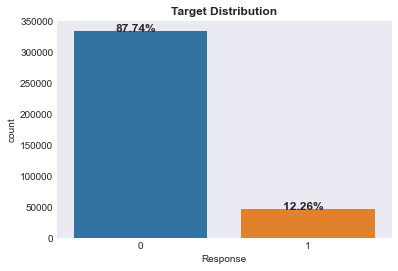

In [38]:
ax = sns.countplot('Response', data=train)
plt.title('Target Distribution', fontweight='bold')
for i in ax.patches:
    plt.text(x=i.get_x()+0.25, y=i.get_height()+0.3, 
             s=str(round(i.get_height()/train.shape[0] * 100, 2))+'%', 
             fontsize=12, fontweight='bold')

#### As we can see the target distribution is highly unbalanced. We will deal with this problem later

In [22]:
train.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [39]:
train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [203]:
cat_cols = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage']
num_cols = [col for col in test.columns if col not in cat_cols and col != 'id']

In [50]:
len(num_cols)+len(cat_cols)

10

In [58]:
train.Vehicle_Age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [204]:
train.Vehicle_Age = train.Vehicle_Age.replace({'< 1 Year' : 1, '1-2 Year' : 2, '> 2 Years' : 3})

test.Vehicle_Age = test.Vehicle_Age.replace({'< 1 Year' : 1, '1-2 Year' : 2, '> 2 Years' : 3})

In [205]:
def linearData():
    train_lin = pd.get_dummies(train, columns=cat_cols, drop_first=True)
    test_lin = pd.get_dummies(test, columns=cat_cols, drop_first=True)
    return train_lin, test_lin

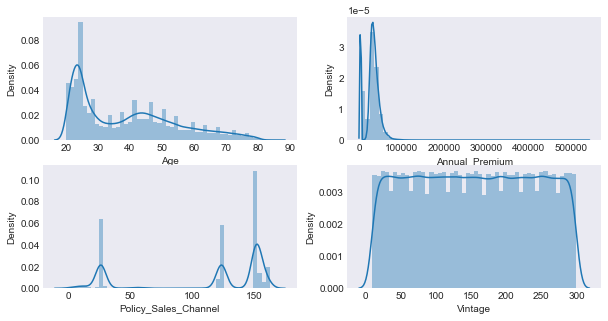

In [65]:
fig, ax = plt.subplots(2,2, figsize=(10,5))
sns.distplot(train.Age, ax=ax[0,0])
sns.distplot(train.Annual_Premium, ax=ax[0,1])
sns.distplot(train.Policy_Sales_Channel, ax=ax[1,0])
sns.distplot(train.Vintage, ax=ax[1,1])
sns.despine();

#### The Annual Premium contains some outliers, so we will use the sqrt function to transform the data distribution

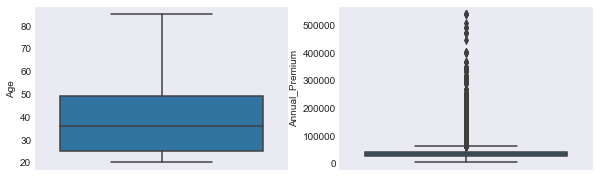

In [76]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.boxplot(y=train.Age, ax=ax[0])
sns.boxplot(y=train.Annual_Premium, ax=ax[1]);

In [206]:
#Transforming Annual Premium distribution
train.Annual_Premium = np.sqrt(train.Annual_Premium)
test.Annual_Premium = np.sqrt(test.Annual_Premium)

In [207]:
#data for linear model
train_lin, test_lin = linearData()

In [208]:
train_lin.shape, test_lin.shape

((381109, 63), (127037, 62))

In [209]:
train.Vehicle_Damage = train.Vehicle_Damage.replace({'No' : 0, 'Yes' : 1})
test.Vehicle_Damage = test.Vehicle_Damage.replace({'No' : 0, 'Yes' : 1})

train.Gender = train.Gender.replace({'Female': 0, 'Male' : 1})
test.Gender = test.Gender.replace({'Female': 0, 'Male' : 1})

#### Modelling

In [210]:
def TrainTestData(train, test): 
    X = train.drop(['id', 'Response'], axis=1)
    test_c = test.drop('id', axis=1)
    return X, test_c

In [216]:
def data_split(X,y):
    xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=seed, 
                                                  test_size=0.3, stratify=y)
    return xtrain, xval, ytrain, yval

In [212]:
X, test_c = TrainTestData(train, test)
y= train.Response

In [289]:
X_lin, test_ln = TrainTestData(train_lin, test_lin)

In [217]:
xtrain_lin, xval_lin, ytrain, yval = data_split(X_lin, y)
xtrain, xval, ytrain, yval = data_split(X, y)

In [218]:
xtrain.shape, xtrain_lin.shape, xval.shape, xval_lin.shape

((266776, 10), (266776, 61), (114333, 10), (114333, 61))

In [308]:
scaler= StandardScaler()
col_transformer = ColumnTransformer(transformers=[('numcols', scaler, num_cols)], 
                                    remainder='passthrough', n_jobs=-1)

In [227]:
logreg = LogisticRegression(random_state=seed, n_jobs=-1, max_iter=250, C=5)

rf_gf = RGFClassifier()

rf = RandomForestClassifier(random_state=seed, min_samples_leaf=10, min_samples_split=10, criterion='entropy',
                            max_samples=0.85, n_estimators=600, n_jobs=-1, warm_start=True)

catm = cat.CatBoostClassifier(random_seed=seed, early_stopping_rounds=250, silent=True, n_estimators=1000,
                              learning_rate=0.07)

lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=1000, learning_rate=0.04,
                         subsample=0.8, colsample_bytree=0.8, num_leaves=40)

gb = GradientBoostingClassifier(random_state=seed, learning_rate=0.08, n_estimators=700, n_iter_no_change=200,
                                subsample=0.8, min_samples_leaf=5, min_samples_split=10, warm_start=True, 
                                validation_fraction=0.2)

ext = ExtraTreesClassifier(random_state=seed, min_samples_leaf=7, min_samples_split=10, n_jobs=-1, n_estimators=600,
                           max_samples=0.8, criterion='entropy')

In [310]:
logreg_pl = Pipeline([('coltrans', col_transformer), ('logreg', logreg)])

#### Training

In [229]:
def plotImportance(model, title=None, ax=None):
    imp = pd.Series(model.feature_importances_, index=xtrain.columns).sort_values()
    imp.plot.barh(title=title)
    if ax:
        imp.plot.barh(ax=ax, title=title)

In [230]:
TrainModel(logreg_pl, xtrain_lin, xval_lin);

Train AUC: 0.83803 Train Bal. Acc : 0.50156
Val AUC: 0.84037 Val Bal. Acc : 0.50204


In [231]:
TrainModel(ext, xtrain, xval);

Train AUC: 0.8907 Train Bal. Acc : 0.5004
Val AUC: 0.85586 Val Bal. Acc : 0.50014


In [232]:
TrainModel(rf, xtrain, xval);

Train AUC: 0.9244 Train Bal. Acc : 0.52157
Val AUC: 0.85463 Val Bal. Acc : 0.50583


In [234]:
TrainModel(rf_gf, xtrain, xval);

Train AUC: 0.85339 Train Bal. Acc : 0.5
Val AUC: 0.85505 Val Bal. Acc : 0.5


In [235]:
TrainModel(gb, xtrain, xval);

Train AUC: 0.86356 Train Bal. Acc : 0.50947
Val AUC: 0.85889 Val Bal. Acc : 0.50674


In [236]:
TrainModel(lgbm, xtrain, xval);

Train AUC: 0.8693 Train Bal. Acc : 0.50518
Val AUC: 0.85936 Val Bal. Acc : 0.50346


In [238]:
TrainModel(catm, xtrain, xval);

Train AUC: 0.86601 Train Bal. Acc : 0.50989
Val AUC: 0.85939 Val Bal. Acc : 0.50534


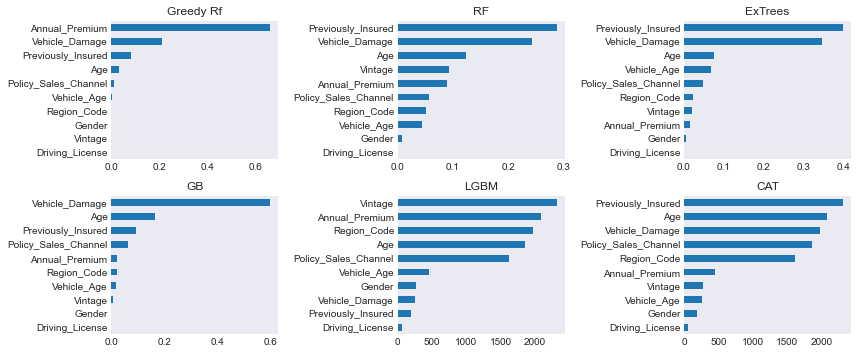

In [240]:
fig,(ax,ax1) = plt.subplots(2,3,figsize=(12,5))
plotImportance(rf_gf, title='Greedy Rf', ax=ax[0])
plotImportance(rf, title='RF', ax=ax[1])
plotImportance(ext, title='ExTrees', ax=ax[2])
plotImportance(gb, title='GB', ax=ax1[0])
plotImportance(lgbm, title='LGBM', ax=ax1[1])
plotImportance(catm, title='CAT', ax=ax1[2])
plt.tight_layout(pad=1.)

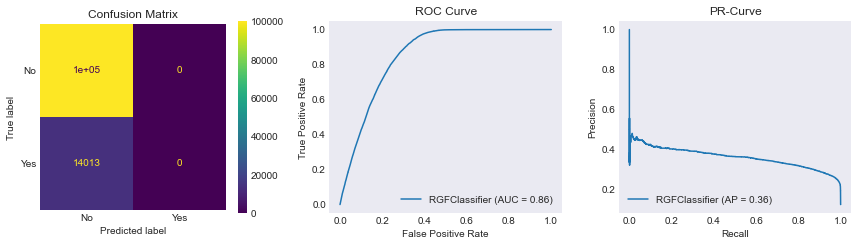

In [263]:
figurePlotting(rf_gf)

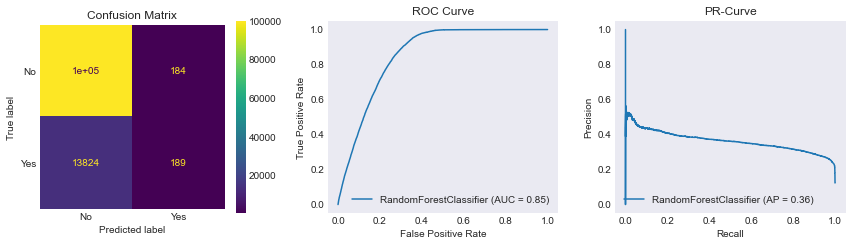

In [264]:
figurePlotting(rf)

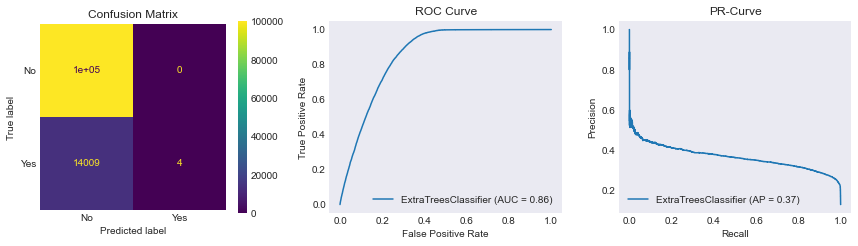

In [265]:
figurePlotting(ext)

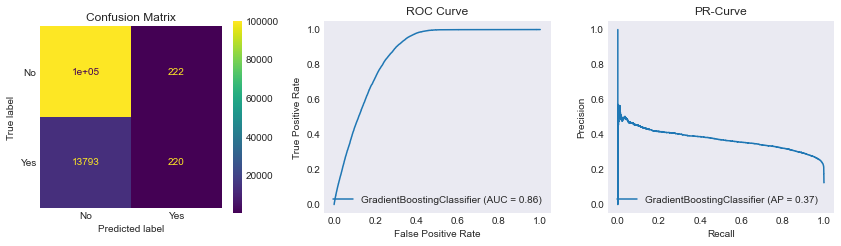

In [266]:
figurePlotting(gb)

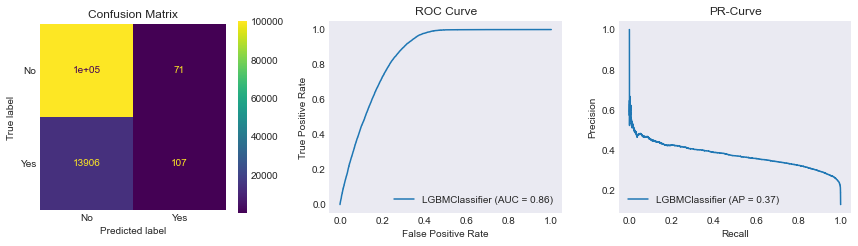

In [267]:
figurePlotting(lgbm)

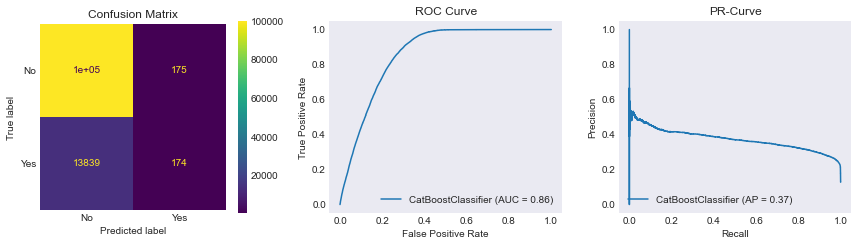

In [268]:
figurePlotting(catm)

#### Predictions

In [277]:
skfold= StratifiedKFold(random_state=seed, shuffle=True)

In [311]:
log_pred = skfoldPred(logreg_pl, X_lin, test_ln)

Fold 1 ===> Val AUC: 0.83706 Val BAS:0.50287
Fold 2 ===> Val AUC: 0.83719 Val BAS:0.50186
Fold 3 ===> Val AUC: 0.83834 Val BAS:0.50164
Fold 4 ===> Val AUC: 0.83856 Val BAS:0.50207
Fold 5 ===> Val AUC: 0.84045 Val BAS:0.50153
AVG AUC: 0.8383212078628046 AVG Bal. ACC: 0.5019921944225192


In [314]:
rf_gf_pred = skfoldPred(rf_gf, X, test_c)

Fold 1 ===> Val AUC: 0.85262 Val BAS:0.5
Fold 2 ===> Val AUC: 0.85146 Val BAS:0.5
Fold 3 ===> Val AUC: 0.85313 Val BAS:0.5
Fold 4 ===> Val AUC: 0.85561 Val BAS:0.5
Fold 5 ===> Val AUC: 0.85498 Val BAS:0.5
AVG AUC: 0.8535597351201151 AVG Bal. ACC: 0.5


In [318]:
rf_pred = skfoldPred(rf, X, test_c)

Fold 1 ===> Val AUC: 0.90385 Val BAS:0.51737
Fold 2 ===> Val AUC: 0.90241 Val BAS:0.51632
Fold 3 ===> Val AUC: 0.90345 Val BAS:0.51613
Fold 4 ===> Val AUC: 0.90472 Val BAS:0.51738
Fold 5 ===> Val AUC: 0.90503 Val BAS:0.51705
AVG AUC: 0.9038924559311331 AVG Bal. ACC: 0.5168498949602776


In [324]:
ext_pred = skfoldPred(ext, X, test_c)

Fold 1 ===> Val AUC: 0.85403 Val BAS:0.50015
Fold 2 ===> Val AUC: 0.85327 Val BAS:0.50021
Fold 3 ===> Val AUC: 0.85422 Val BAS:0.50012
Fold 4 ===> Val AUC: 0.85624 Val BAS:0.50011
Fold 5 ===> Val AUC: 0.85662 Val BAS:0.50011
AVG AUC: 0.8548765019833355 AVG Bal. ACC: 0.5001393943363255


In [323]:
gb_pred = skfoldPred(gb, X, test_c)

Fold 1 ===> Val AUC: 0.86111 Val BAS:0.51131
Fold 2 ===> Val AUC: 0.86169 Val BAS:0.50955
Fold 3 ===> Val AUC: 0.86308 Val BAS:0.50969
Fold 4 ===> Val AUC: 0.8645 Val BAS:0.51021
Fold 5 ===> Val AUC: 0.86562 Val BAS:0.50937
AVG AUC: 0.8632018653566138 AVG Bal. ACC: 0.5100258877761404


In [327]:
lgb_pred = skfoldPred(lgbm, X, test_c)

Fold 1 ===> Val AUC: 0.85768 Val BAS:0.50297
Fold 2 ===> Val AUC: 0.85629 Val BAS:0.50314
Fold 3 ===> Val AUC: 0.85829 Val BAS:0.50316
Fold 4 ===> Val AUC: 0.85947 Val BAS:0.5017
Fold 5 ===> Val AUC: 0.86042 Val BAS:0.50321
AVG AUC: 0.8584311481580194 AVG Bal. ACC: 0.5028372608484496


In [329]:
cat_pred = skfoldPred(catm, X, test_c)

Fold 1 ===> Val AUC: 0.85748 Val BAS:0.50885
Fold 2 ===> Val AUC: 0.85625 Val BAS:0.5088
Fold 3 ===> Val AUC: 0.85852 Val BAS:0.50891
Fold 4 ===> Val AUC: 0.85939 Val BAS:0.50398
Fold 5 ===> Val AUC: 0.8605 Val BAS:0.50773
AVG AUC: 0.8584286014736755 AVG Bal. ACC: 0.5076530216334731


In [373]:
blend = 0.05*log_pred + 0.075*rf_pred + 0.1*rf_gf_pred + 0.125*ext_pred + 0.15*gb_pred + 0.25*cat_pred + 0.25*lgb_pred

#### Submission

In [336]:
log_df = subfile.copy()
log_df['Response'] = log_pred

In [338]:
lgb_df = subfile.copy()
lgb_df['Response'] = lgb_pred

In [339]:
ext_df = subfile.copy()
ext_df['Response'] = ext_pred

In [340]:
rf_df = subfile.copy()
rf_df['Response'] = rf_pred

In [341]:
rgf_df = subfile.copy()
rgf_df['Response'] = rf_gf_pred

In [342]:
gb_df = subfile.copy()
gb_df['Response'] = gb_pred

In [343]:
cat_df = subfile.copy()
cat_df['Response'] = cat_pred

In [376]:
blend_df = subfile.copy()
blend_df['Response'] = blend

In [377]:
pd.DataFrame(np.c_[log_pred, rf_pred, rf_gf_pred, ext_pred, gb_pred, lgb_pred, cat_pred,blend],
            columns=['LogReg', 'RF', 'RGF', 'ExTrees', 'GB', 'LGB', 'CAT', 'Blend']).corr()

,LogReg,RF,RGF,ExTrees,GB,LGB,CAT,Blend
LogReg,1.000000,0.906910,0.938940,0.940169,0.914026,0.920806,0.917766,0.933816
RF,0.906910,1.000000,0.969027,0.982665,0.975409,0.981685,0.980555,0.985717
RGF,0.938940,0.969027,1.000000,0.986453,0.974654,0.981668,0.978307,0.987599
ExTrees,0.940169,0.982665,0.986453,1.000000,0.976334,0.984350,0.983485,0.991325
GB,0.914026,0.975409,0.974654,0.976334,1.000000,0.992305,0.993595,0.993819
LGB,0.920806,0.981685,0.981668,0.984350,0.992305,1.000000,0.996413,0.997761
CAT,0.917766,0.980555,0.978307,0.983485,0.993595,0.996413,1.000000,0.997308
Blend,0.933816,0.985717,0.987599,0.991325,0.993819,0.997761,0.997308,1.000000


In [378]:
pd.DataFrame(np.c_[log_pred, rf_pred, rf_gf_pred, ext_pred, gb_pred, lgb_pred, cat_pred, blend],
            columns=['LogReg', 'RF', 'RGF', 'ExTrees', 'GB', 'LGB', 'CAT', 'Blend'])

,LogReg,RF,RGF,ExTrees,GB,LGB,CAT,Blend
0,0.000874,0.000076,0.002260,0.000329,0.000833,0.000404,0.000629,0.000700
1,0.372747,0.325232,0.319443,0.326207,0.296812,0.312345,0.309039,0.315618
2,0.268362,0.261629,0.308071,0.282566,0.306161,0.298379,0.296494,0.293811
3,0.002912,0.012586,0.010105,0.012680,0.006244,0.008358,0.010632,0.009369
4,0.000631,0.001630,0.002416,0.000571,0.000426,0.000354,0.000357,0.000708
...,...,...,...,...,...,...,...,...
127032,0.000352,0.000006,0.002137,0.001618,0.000693,0.000286,0.000350,0.000697
127033,0.286053,0.372380,0.345109,0.348370,0.361298,0.362366,0.364720,0.356254
127034,0.000606,0.000008,0.002259,0.000269,0.000679,0.000207,0.000255,0.000508
127035,0.000686,0.000318,0.003588,0.000180,0.000529,0.000200,0.000061,0.000584


In [346]:
os.mkdir('predictions')

In [379]:
log_df.to_csv('predictions/logreg_bl.csv', index=False)
rf_df.to_csv('predictions/rf_bl.csv', index=False)
rgf_df.to_csv('predictions/rgf_bl.csv', index=False)
ext_df.to_csv('predictions/extrees_bl.csv', index=False)
gb_df.to_csv('predictions/gb_bl.csv', index=False)
lgb_df.to_csv('predictions/lgb_bl.csv', index=False)
cat_df.to_csv('predictions/cat_bl.csv', index=False)
blend_df.to_csv('predictions/blend_bl.csv', index=False)

In [380]:
gc.collect()

13893